# Taxi fare - exploration and prediction
<hr>

The below is an exploration of the taxi fare data received. 

The first section is an exploratory data analysis, that looks to understand the relationship between the variables and try to identify if any significant relation is present between the target variable and the other variables.

The second section is on modelling, trying to see how to best predict the target variable. It includes creating a simple linear model, using cross validation to determine model performance, as well as a custom defined function to cross compare models.
 

#### Taxi Fares
The data set contains the following variables:
- key - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field. 
- pickup_datetime - timestamp value indicating when the taxi ride started.
- pickup_longitude - float for longitude coordinate of where the taxi ride started.
- pickup_latitude - float for latitude coordinate of where the taxi ride started.
- dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
- dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
- passenger_count - integer indicating the number of passengers in the taxi ride.
- fare_amount - float dollar amount of the cost of the taxi ride. 

In [1]:
import datetime
import warnings
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
sns.set()

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
import scipy.stats as stats
from sklearn.model_selection import cross_validate, KFold

from sklearn.model_selection import  train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV

import pickle
from haversine import haversine # this is a custom function that calculates distances using the great circle distance.

### 1. Exploratory Data Analysis

In [2]:
df = pd.read_csv('fare_data.csv', parse_dates=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                50000 non-null  object 
 1   fare_amount        50000 non-null  float64
 2   pickup_datetime    50000 non-null  object 
 3   pickup_longitude   50000 non-null  float64
 4   pickup_latitude    50000 non-null  float64
 5   dropoff_longitude  50000 non-null  float64
 6   dropoff_latitude   50000 non-null  float64
 7   passenger_count    50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [4]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

In [5]:
df.shape

(50000, 8)

In [6]:
df.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

There are no missing values in the dataset. 

In [7]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


Let's define the target variable as a python variable. 

In [8]:
target='fare_amount'

Adding two plots to get a basic understanding of the distribution of the target variable.

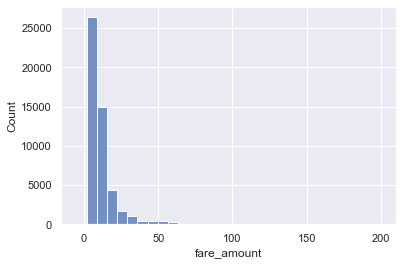

In [9]:
sns.histplot(df[target], bins = 30);

The data is obviously skewed to the right, and is similar to a power law distribution. 

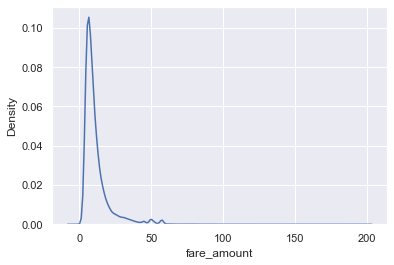

In [10]:
sns.kdeplot(data = df, x = target);

In [11]:
desc_stats = df[target].describe(percentiles =[0.1,0.25,0.5,0.75,0.9,0.95,0.99])
desc_stats

count    50000.000000
mean        11.364171
std          9.685557
min         -5.000000
10%          4.500000
25%          6.000000
50%          8.500000
75%         12.500000
90%         20.500000
95%         30.500000
99%         52.000000
max        200.000000
Name: fare_amount, dtype: float64

In [12]:
ninetynineth = desc_stats["99%"]
lower = desc_stats["25%"]
upper = desc_stats["75%"]
iqr = upper - lower

In [13]:
lower_bound = lower-(iqr*1.5)
upper_bound = upper+(iqr*1.5)

In [14]:
print(f'***{target}***\noutlier upper boundary for {target}: {upper_bound}\noutlier lower boundary for {target}: {lower_bound}')
num_outliers = len(df[target].loc[(df[target]<lower_bound) | (df[target]>upper_bound)])
print(f'total number of outliers: {num_outliers}\noutlier percentage: {(num_outliers/len(df))*100:.2f}%')

***fare_amount***
outlier upper boundary for fare_amount: 22.25
outlier lower boundary for fare_amount: -3.75
total number of outliers: 4365
outlier percentage: 8.73%


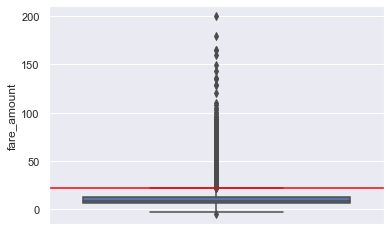

In [15]:
graph = sns.boxplot(data = df, y = target)
graph.axhline(upper_bound, color = 'red');

In [16]:
len(df[df[target]>0])

49991

As there are only 9 rows with negative rowcounts, I am dropping them.

In [17]:
df = df[df[target]>0]

In [18]:
df.shape

(49991, 8)

Creating column charts by the number of rides per day of the week and hour of the day

In [19]:
df['pickup_day'] = df['pickup_datetime'].dt.day_name()

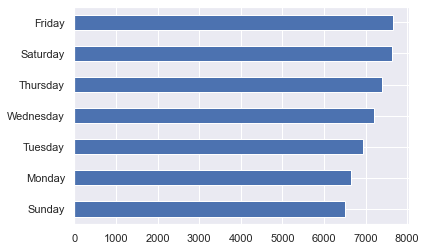

In [20]:
df['pickup_day'].value_counts().sort_values().plot(kind = 'barh');

From the above barchart it is visible that the most popular days are Fridays and Saturdays. The least popular days are Sundays and Mondays, and there is no significant trend of diminishing apparent in the data.

In [21]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour

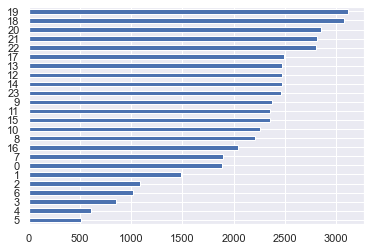

In [22]:
df['pickup_hour'].value_counts().sort_values().plot(kind='barh');

The most common pickup time is in the evening, around 7 PM. There is an obvious and sudden decrease in the data, the number of taxi rides are significantly less during the night, than in the day. Most taxi rides take place during the second half of the day. 

#### Let's have a look at how the different days compare to regarding pickup hour

In [23]:
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

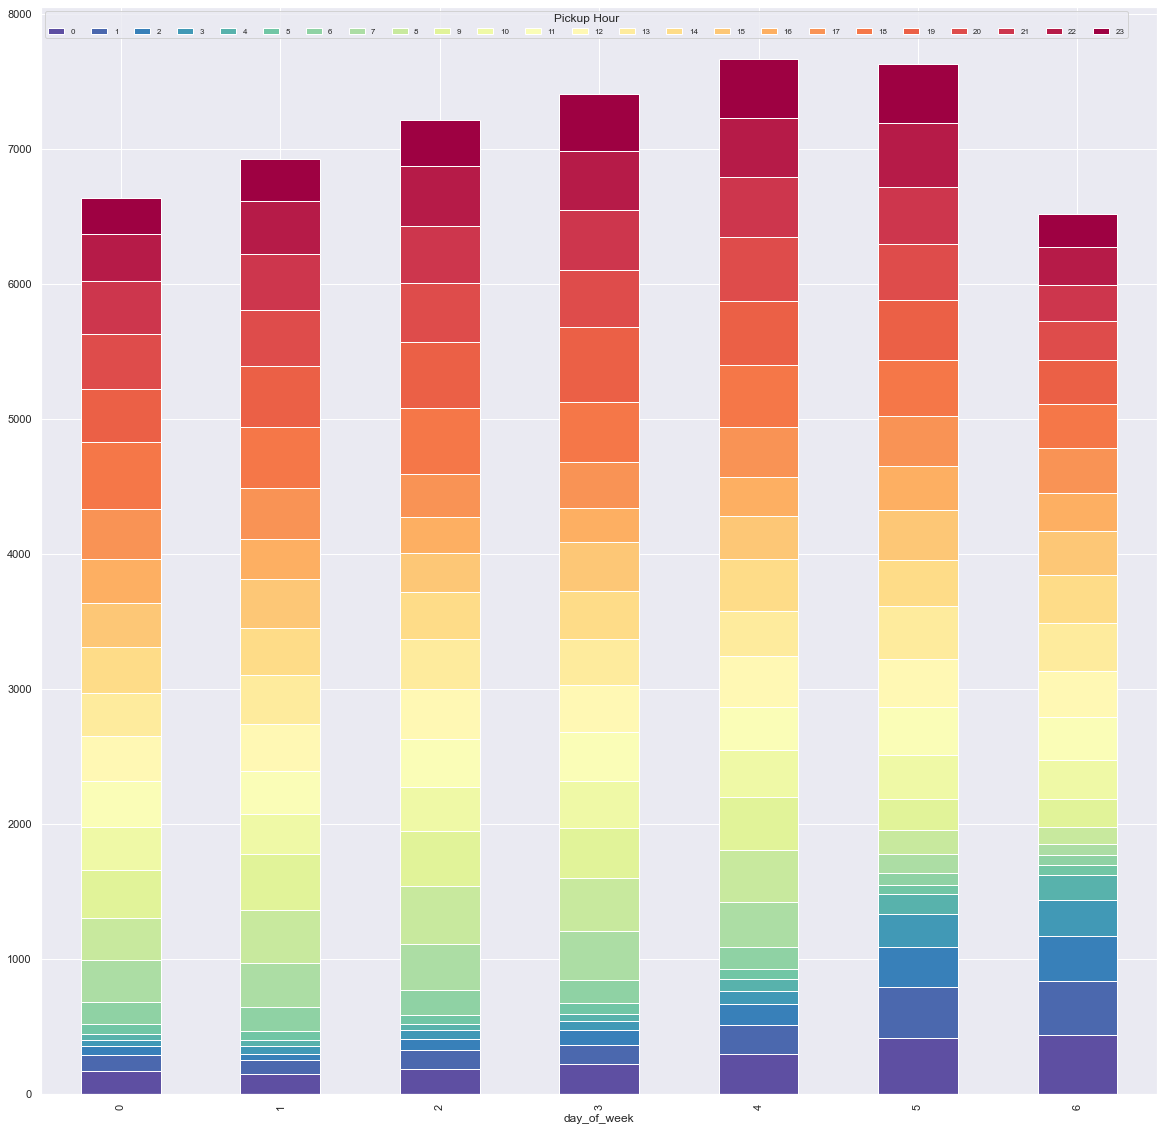

In [24]:
pd.crosstab(df['day_of_week'],df['pickup_hour']).plot(kind='bar', stacked=True, figsize=(20,20), cmap='Spectral_r');
plt.legend(loc='upper left', title='Pickup Hour', prop={'size': 8}, ncol=24);

The stacked column chart showcases the days of the week, and the different colours show the hours in the day, indicating whether it is in the morning, during the day or at night. 

#### Identify outliers 
Is there a relationship with any of the relavant variables? 

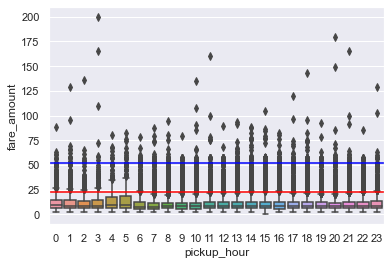

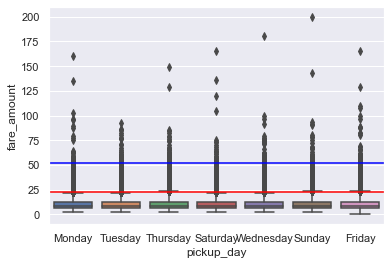

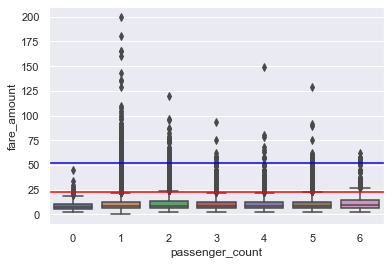

<Figure size 432x288 with 0 Axes>

In [25]:
for col in ['pickup_hour','pickup_day', 'passenger_count']:
    graph = sns.boxplot(data=df, x=col, y='fare_amount')
    graph.axhline(ninetynineth, color = 'blue')
    graph.axhline(upper_bound, color = 'red')
    plt.figure();

The purpose of the following boxplots is to try and identify any patterns in the data, to see if there can be any relationships between pickup day, pickup hour, passenger count and fare amount. <br>
In the above boxplots all data above the red horizontal line are outliers for the fare_amount (total). Anything above the blue line is above the 99th percentile for the total fare amount.

### create pickup and dropoff locations

In [26]:
df['pickup_location'] = list(zip(df['pickup_latitude'],df['pickup_longitude']))

In [27]:
df['dropoff_location'] = list(zip(df['dropoff_latitude'],df['dropoff_longitude']))

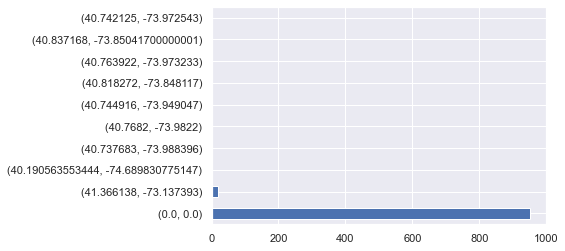

In [28]:
df['pickup_location'].value_counts()[:10].plot(kind='barh');

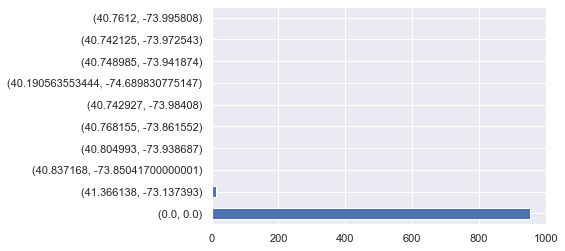

In [29]:
df['dropoff_location'].value_counts()[:10].plot(kind='barh');

#### drop values where pickup location or dropoff location is 0.0

In [30]:
len(df)-len(df[(df['dropoff_location'] != (0.0,0.0)) & (df['pickup_location'] != (0.0,0.0))])

993

There are quite a few locations where the pickup or the dropoff location is equal to (0,0), however this is unlikely to be an actual dropoff location for a taxi ride as it is located in the Atlantic Ocean about 200 km's from the coast of Africa.

In [31]:
df = df[(df['dropoff_location'] != (0.0,0.0)) & (df['pickup_location'] != (0.0,0.0))]

In [32]:
df.shape

(48998, 13)

#### Identifying location hotspots

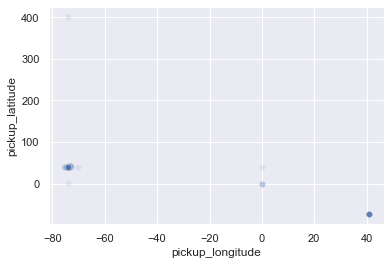

In [33]:
sns.scatterplot(data = df, x='pickup_longitude', y='pickup_latitude', alpha = 0.1);

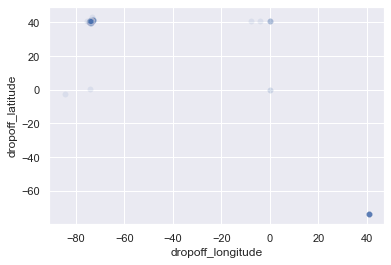

In [34]:
sns.scatterplot(data = df, x='dropoff_longitude', y='dropoff_latitude',alpha = 0.1);

There still appear data that require additional cleaning.

In [35]:
# identify minimum and maximum longitudes
min(df.pickup_longitude.min(), df.dropoff_longitude.min()), \
max(df.pickup_longitude.max(), df.dropoff_longitude.max())

(-84.654241, 40.851027)

In [36]:
# identify minimum and maximum latitudes
min(df.pickup_latitude.min(), df.dropoff_latitude.min()), \
max(df.pickup_latitude.max(), df.dropoff_latitude.max())

(-74.006893, 401.083332)

In [37]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,day_of_week
count,48998.000000,48998.000000,48998.000000,48998.000000,48998.000000,48998.000000,48998.000000,48998.000000
mean,11.362548,-73.923101,40.709649,-73.916364,40.703651,1.669313,13.482734,3.031083
std,9.655406,2.379352,2.814481,2.464735,2.289363,1.290245,6.503820,1.956450
min,0.010000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000,0.000000,0.000000
25%,6.000000,-73.992297,40.736464,-73.991325,40.735861,1.000000,9.000000,1.000000
50%,8.500000,-73.982115,40.753412,-73.980466,40.754076,1.000000,14.000000,3.000000
75%,12.500000,-73.968350,40.767755,-73.965262,40.768476,2.000000,19.000000,5.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000,23.000000,6.000000


There are still some values in the data that have to be cleaned. Longitude cannot have a value of 401.08, that is impossible.

### Focus on new york

My suggestion is to focus on New York city, as most of the values in the above table pinpoint that location.

In [38]:
ny_min_lat = 40.5
ny_min_lon = -74.5
ny_max_lat = 41.8
ny_max_lon = -72.8

In [39]:
df = df[(df['pickup_latitude']<ny_max_lat) &
        (df['pickup_longitude']<ny_max_lon) &
        (df['dropoff_latitude']<ny_max_lat) &
        (df['dropoff_longitude']<ny_max_lon)&
        (df['pickup_latitude']>ny_min_lat) &
        (df['pickup_longitude']>ny_min_lon) &
        (df['dropoff_latitude']>ny_min_lat) &
        (df['dropoff_longitude']>ny_min_lon)]
df.shape

(48935, 13)

### Identifying pickup and dropoff hotspots

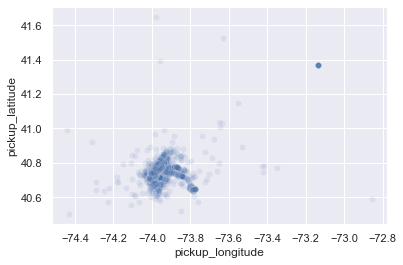

In [40]:
sns.scatterplot(data = df, x='pickup_longitude', y='pickup_latitude', alpha = 0.1);

In [41]:
df['pickup_longitude'].apply(lambda x: round(x,2)).value_counts().iloc[:5]

-73.99    11253
-73.98    11007
-73.97     6653
-74.00     5921
-73.96     4689
Name: pickup_longitude, dtype: int64

In [42]:
df['pickup_latitude'].apply(lambda x: round(x,2)).value_counts().iloc[:5]

40.76    9487
40.75    7593
40.77    6693
40.74    6292
40.73    4767
Name: pickup_latitude, dtype: int64

The top pickup location is around Time Square

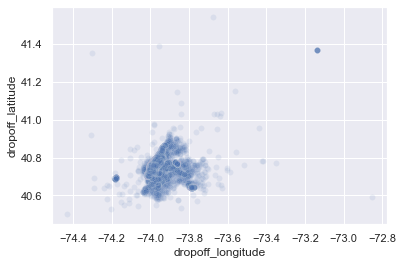

In [43]:
sns.scatterplot(data = df, x='dropoff_longitude', y='dropoff_latitude',alpha = 0.1);

In [44]:
df['dropoff_longitude'].apply(lambda x: round(x,2)).value_counts().iloc[:5]

-73.98    11286
-73.99    10007
-73.97     6486
-74.00     5265
-73.96     4693
Name: dropoff_longitude, dtype: int64

In [45]:
df['dropoff_latitude'].apply(lambda x: round(x,2)).value_counts().iloc[:5]

40.76    9412
40.75    7591
40.77    6076
40.74    5676
40.73    4192
Name: dropoff_latitude, dtype: int64

The top dropoff location is also Times Square, however based on the above scatterplot, there is a clear hotpot around(40.69,-74.18): the <i>Newark Liberty International Airport</i> in New Yersey.

### Calculate the air distance using the great circle distance
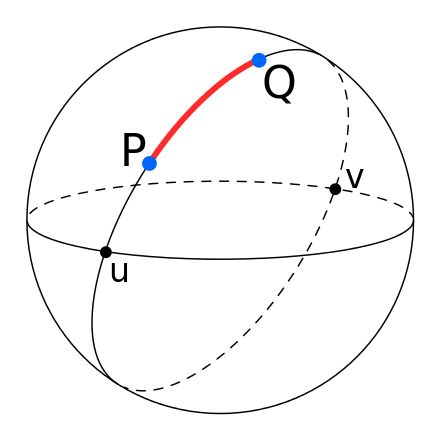
Due to the curvature of the Earth, calculating the distances on an Euclidean plane would yield incorrect results, hence the haversine function is used to calculate the great cirle distance between 2 locations.

In [46]:
df['air_distance'] = [haversine(df['pickup_location'].iloc[_],df['dropoff_location'].iloc[_]) for _ in range(len(df))]
df['air_distance'].describe()

count    48935.000000
mean      2731.801614
std       4039.653499
min          0.000000
25%        851.000000
50%       1561.000000
75%       2858.000000
max      99389.000000
Name: air_distance, dtype: float64

In [47]:
df[df['air_distance'] == 0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,day_of_week,pickup_location,dropoff_location,air_distance
105,2009-03-25 00:08:52.0000001,52.00,2009-03-25 00:08:52+00:00,-74.035839,40.747320,-74.035839,40.747320,1,Wednesday,0,2,"(40.74732, -74.035839)","(40.74732, -74.035839)",0
191,2014-01-08 21:55:58.0000006,6.50,2014-01-08 21:55:58+00:00,-73.998488,40.726303,-73.998488,40.726303,1,Wednesday,21,2,"(40.726303, -73.998488)","(40.726303, -73.998488)",0
270,2012-08-25 01:53:42.0000005,7.50,2012-08-25 01:53:42+00:00,-73.995892,40.746454,-73.995892,40.746454,1,Saturday,1,5,"(40.746454, -73.995892)","(40.746454, -73.995892)",0
290,2009-12-14 12:33:00.00000075,6.90,2009-12-14 12:33:00+00:00,-73.982432,40.745747,-73.982432,40.745747,1,Monday,12,0,"(40.745747, -73.98243199999999)","(40.745747, -73.98243199999999)",0
396,2014-03-12 18:12:44.0000006,12.00,2014-03-12 18:12:44+00:00,-73.844904,40.736318,-73.844904,40.736318,1,Wednesday,18,2,"(40.736318, -73.844904)","(40.736318, -73.844904)",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49721,2009-11-16 11:27:00.000000165,4.10,2009-11-16 11:27:00+00:00,-73.974603,40.762377,-73.974603,40.762377,5,Monday,11,0,"(40.762377, -73.974603)","(40.762377, -73.974603)",0
49774,2010-02-15 19:31:00.00000054,49.57,2010-02-15 19:31:00+00:00,-73.925295,40.733120,-73.925295,40.733120,2,Monday,19,0,"(40.73312, -73.92529499999999)","(40.73312, -73.92529499999999)",0
49783,2011-11-27 06:00:42.0000001,4.50,2011-11-27 06:00:42+00:00,-73.975402,40.699535,-73.975402,40.699535,1,Sunday,6,6,"(40.699535, -73.975402)","(40.699535, -73.975402)",0
49799,2010-01-19 15:54:56.0000004,4.10,2010-01-19 15:54:56+00:00,-73.943283,40.746815,-73.943283,40.746815,2,Tuesday,15,1,"(40.746815000000005, -73.943283)","(40.746815000000005, -73.943283)",0


There are 557 rows where the distance travelled in air is equal to zero. I'll drop these as well, as they appear to be counterintuitive.

In [48]:
# drop items where distance travelled == 0
df = df[df['air_distance'] > 0]

In [49]:
df.shape

(48378, 14)

In [50]:
df['passenger_count'].describe()

count    48378.000000
mean         1.670780
std          1.291948
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

In [51]:
len(df[df['passenger_count'] == 0])

158

There are also some columns where the passenger count is equal to zero. As we are interested in passenger transport, I'll drop these values as well.

In [52]:
df = df[df['passenger_count'] > 0]

In [53]:
df.shape

(48220, 14)

### Using a correlation matrix to identify columns that could be used for modelling

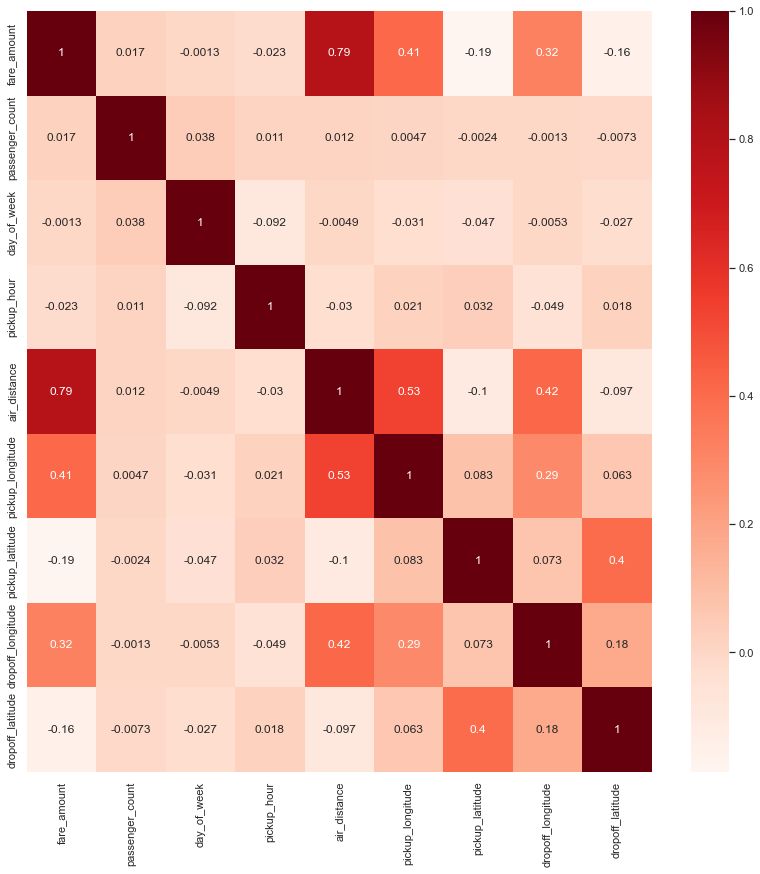

In [54]:
plt.subplots(figsize=(14,14))
sns.heatmap(df[['fare_amount','passenger_count','day_of_week','pickup_hour','air_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].corr(), cmap = 'Reds',annot = True);

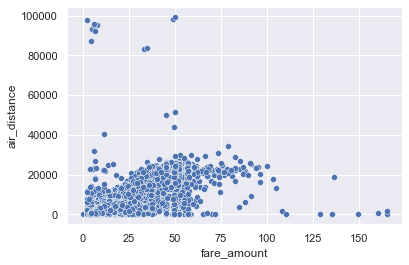

In [55]:
sns.scatterplot(data = df, x = 'fare_amount', y='air_distance');

The above scatterplot shows the fare amount on the x-axis and the air-distance on the y-axis. There are some outliers in the air distance, which are worth examining further.

In [56]:
df['air_distance'].describe(percentiles = [0.1,0.25,0.5,0.75,0.9,0.99])

count    48220.000000
mean      2764.241622
std       4055.044998
min          1.000000
10%        497.000000
25%        872.000000
50%       1580.000000
75%       2882.000000
90%       5222.100000
99%      22103.240000
max      99389.000000
Name: air_distance, dtype: float64

In [57]:
len(df[df['air_distance']>22104])

482

Again, there are some records, where the distance travelled is significantly larger than the 99th percentile, I'll drop these again for the purposes of the model.

In [58]:
df = df[df['air_distance']<=22104]

In [59]:
len(df)

47738

Let's create a histogram to identify whether there are any patterns in the distribution of air distance. 

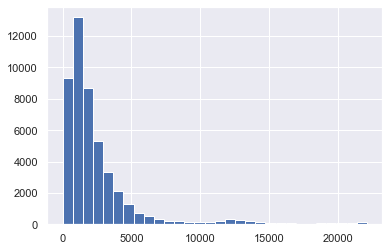

In [60]:
df['air_distance'].hist(bins=30);

In [61]:
df['air_distance'].describe(percentiles = [0.1,0.25,0.5,0.75,0.9,0.99])

count    47738.000000
mean      2534.359357
std       3174.572971
min          1.000000
10%        495.000000
25%        867.000000
50%       1564.000000
75%       2817.000000
90%       4931.000000
99%      18147.670000
max      22104.000000
Name: air_distance, dtype: float64

In [62]:
df[df['air_distance'] == df['air_distance'].max()]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,day_of_week,pickup_location,dropoff_location,air_distance
44299,2012-10-08 07:47:18.0000003,56.8,2012-10-08 07:47:18+00:00,-73.987184,40.733067,-73.789837,40.646992,1,Monday,7,0,"(40.733067, -73.987184)","(40.646992, -73.789837)",22104


Let's see if the above pattern can be further be examined by focusing on the 95% of the remaining dataset.

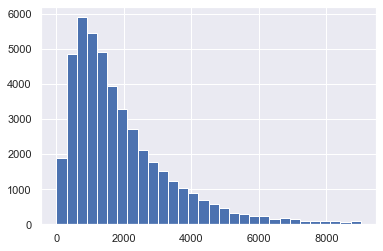

In [63]:
df[df['air_distance'] < df['air_distance'].describe(percentiles = [0.95])['95%']]['air_distance'].hist(bins=30);

The above histogram appears to show a distribution similar to a Poisson distribution with a low lambda. 

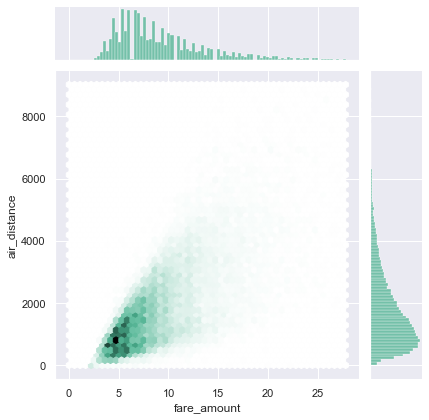

In [64]:
sns.jointplot(data=df[(df['air_distance'] < df['air_distance'].describe(percentiles = [0.95])['95%']) &
                      (df['fare_amount'] < df['fare_amount'].describe(percentiles = [0.95])['95%'])],
              x='fare_amount', y='air_distance', kind="hex", color="#4CB391");

From the above jointplot and the correlation between air distance and the fare amount, I conclude that air distance could be a good predictor for fare amount. 

## 2. Modelling

### Fit baseline model - linear regression

In the following section, I will fit and evaluate different models. I'll start by fitting a baseline linear regression with a subset of the features. I'll then expand the model to contain all features examined. In the following section I'll run a cross validation using scikit-learn's own cross validator, then create a self defined function that randomly splits the data then trains and evaluates a set of predefined models. In the final section I will create a simple pipeline that could be used to deploy the winning model.

In [65]:
X = df[['passenger_count','day_of_week','pickup_hour','air_distance']]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [66]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [67]:
predictions = model.predict(X_test)
r2 = r2_score(y_true=y_test, y_pred=predictions)
mae = mean_absolute_error(y_true=y_test, y_pred=predictions)
rmse = mean_squared_error(y_true=y_test, y_pred=predictions) ** 0.5

print(f'r2: {r2}\nmean abs error: {mae}\nroot mean sq error: {rmse}')

r2: 0.6882431500746666
mean abs error: 2.940988466253487
root mean sq error: 4.837014769796477


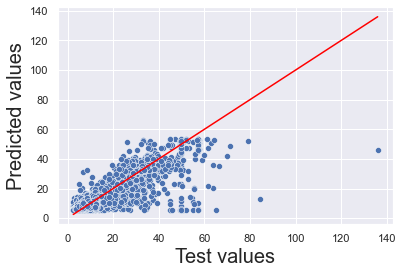

In [68]:
sns.lineplot(x=y_test,y=y_test, color='red')
p = sns.scatterplot(x=y_test,y=predictions)

p.set_xlabel("Test values", fontsize = 20)
p.set_ylabel("Predicted values", fontsize = 20);

### Adding additional columns to the model

In [69]:
X = df[['passenger_count','day_of_week','pickup_hour','air_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [70]:
model2 = LinearRegression()
model2.fit(X_train, y_train)

LinearRegression()

In [71]:
predictions = model2.predict(X_test)
r2_m2 = r2_score(y_true=y_test, y_pred=predictions)
mae_m2 = mean_absolute_error(y_true=y_test, y_pred=predictions)
rmse_m2 = mean_squared_error(y_true=y_test, y_pred=predictions) ** 0.5

In [72]:
print(f'r2: {r2_m2}\nmean abs error: {mae_m2}\nroot mean sq error: {rmse_m2}')

r2: 0.6686264448331724
mean abs error: 2.903431009169593
root mean sq error: 4.962844847075648


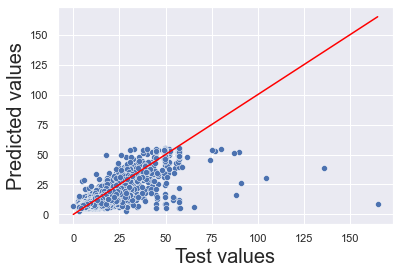

In [73]:
sns.lineplot(x=y_test,y=y_test, color='red')
p = sns.scatterplot(x=y_test,y=predictions)

p.set_xlabel("Test values", fontsize = 20)
p.set_ylabel("Predicted values", fontsize = 20);

### Cross Validating the latter model

In [74]:
scorers = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']
x_df = pd.DataFrame(cross_validate(model, X, y, cv=KFold(5),scoring=scorers, return_estimator=False))
x_df

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error
0,0.009956,0.003001,0.677652,-2.863401,-22.725947
1,0.010036,0.002014,0.698621,-2.914143,-21.772496
2,0.009973,0.002032,0.639771,-2.951001,-26.990614
3,0.008000,0.001999,0.663967,-2.955190,-24.991427
4,0.008000,0.000999,0.638187,-2.976053,-27.296699


## Compare multiple models based on their performance

In [75]:
models = {
    'linear_regression': LinearRegression(),
    'ridge': Ridge(),
    'random_forest': RandomForestRegressor()
}
# %%

In [76]:
def compare_models(models,X,y,no_iterations = 3):
    model_scores = pd.DataFrame(columns=[0, 1, 2])
    for i in range(no_iterations):
        model_scores = model_scores.append(pd.DataFrame.from_dict({0:['*'],1:[f'iteration {i+1}'],2:['*']}))
        for name, model in models.items():
            X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
            print(f'fitting model: {name} on iteration {i}')
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            r2 = r2_score(y_true=y_test , y_pred=predictions)
            mae = mean_absolute_error(y_true=y_test, y_pred=predictions)
            rmse = mean_squared_error(y_true=y_test, y_pred=predictions) ** 0.5
            df1 = pd.DataFrame({name: [r2, mae, rmse]}).transpose()
            model_scores = model_scores.append(df1)
    model_scores.rename(
        columns={0: 'R2', 1: 'mean_absolute_error', 2: 'root_mean_squared_error'}, inplace=True)
    return model_scores

In [77]:
a = compare_models(models,X,y)

a

fitting model: linear_regression on iteration 0
fitting model: ridge on iteration 0
fitting model: random_forest on iteration 0
fitting model: linear_regression on iteration 1
fitting model: ridge on iteration 1
fitting model: random_forest on iteration 1
fitting model: linear_regression on iteration 2
fitting model: ridge on iteration 2
fitting model: random_forest on iteration 2


,R2,mean_absolute_error,root_mean_squared_error
0,*,iteration 1,*
linear_regression,0.673025,2.933044,4.817205
ridge,0.68649,2.938439,4.76074
random_forest,0.796194,2.025717,3.903224
0,*,iteration 2,*
linear_regression,0.693516,2.877028,4.727085
ridge,0.65184,2.933265,5.08888
random_forest,0.80648,2.068635,3.753896
0,*,iteration 3,*
linear_regression,0.628056,3.001082,5.408084


The above table is the result of splitting the data 3 times and then training and evaluating model performance. In the above table the best performer is the random forest regressor, based on all 3 metrics. $R^2$ measures the variance explained by the model, while mean absolute error and root mean squared error measure the prediction error from the actual value. However, as mean squared error sums up the squares of errors, it penalizes larger errors more than the mean absolute error.

#### Parameter tuning

The following is a limited attempt at tuning the parameters of the winning random forest regressor. The limitation is due to time and computational constraints. For better model performance it is worth experimenting by changing the number of estimators, the depth of the decision tree and the number of saples required per leaf or per split. Also, the number of iterations have been decreased significantly to improve training speed. 

In [78]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [79]:
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=3, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=3)

In [80]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [81]:
def evaluate_model(model, X_test = X_test, y_test=y_test):
    predictions = model.predict(X_test)
    r2 = r2_score(y_true=y_test , y_pred=predictions)
    mae = mean_absolute_error(y_true=y_test, y_pred=predictions)
    rmse = mean_squared_error(y_true=y_test, y_pred=predictions) ** 0.5
    print(f'R^2: {r2}\nmean absolute error: {mae}\nroot mean squared error: {rmse}')

In [82]:
evaluate_model(rf_random)

R^2: 0.7520656018248498
mean absolute error: 2.057245906078774
root mean squared error: 4.292795171051993


These results can also be further improved using a grid search.

### create a simple pipeline to deliver the winning model

In [83]:
class FitModel():
    """
    The below is a simple attempt to create a delivery pipeline. The transform method does the data cleaning as done in the first
    part of the notebook, while the train model trains and returns a final model. 
    """
    def __init__(self,df):
        self.df = df
        self.ny_min_lat = 40.5
        self.ny_min_lon = -74.5
        self.ny_max_lat = 41.8
        self.ny_max_lon = -72.8
        self.target = 'fare_amount'
    def transform(self):
        self.df.loc[:,"pickup_datetime"] = pd.to_datetime(self.df["pickup_datetime"])
        self.df = self.df[self.df[target]>0]
        self.df.loc[:,'pickup_hour'] = self.df.loc[:,'pickup_datetime'].dt.hour
        self.df.loc[:,'day_of_week'] = self.df.loc[:,'pickup_datetime'].dt.dayofweek
        self.df = self.df[(self.df['pickup_latitude']<self.ny_max_lat) &
            (self.df['pickup_longitude']<self.ny_max_lon) &
            (self.df['dropoff_latitude']<self.ny_max_lat) &
            (self.df['dropoff_longitude']<self.ny_max_lon)&
            (self.df['pickup_latitude']>self.ny_min_lat) &
            (self.df['pickup_longitude']>self.ny_min_lon) &
            (self.df['dropoff_latitude']>self.ny_min_lat) &
            (self.df['dropoff_longitude']>self.ny_min_lon)]
        self.df.loc[:,'pickup_location'] = list(zip(self.df['pickup_latitude'],self.df['pickup_longitude']))
        self.df.loc[:,'dropoff_location'] = list(zip(self.df['dropoff_latitude'],self.df['dropoff_longitude']))
        self.df.loc[:,'air_distance'] = [haversine(self.df['pickup_location'].iloc[_],self.df['dropoff_location'].iloc[_]) for _ in range(len(self.df))]
    def train_model(self,model = None):
        # if no model is passed then the result paramaters of the previous random search is passed. 
        if not model:
        
            model = RandomForestRegressor(n_estimators = 1000, min_samples_split = 5, min_samples_leaf = 2,
                 max_features= 'auto',max_depth= 50,bootstrap= True)
        X = self.df[['passenger_count','day_of_week','pickup_hour','air_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]
        y = self.df[target]
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
        print(f'Fitting model')
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        r2 = r2_score(y_true=y_test , y_pred=predictions)
        mae = mean_absolute_error(y_true=y_test, y_pred=predictions)
        rmse = mean_squared_error(y_true=y_test, y_pred=predictions) ** 0.5
        print('The model is trained and ready to be shipped as a pickle file with the following attributes:')
        print(f'R squared: {r2:.3f}\nmean absolute error: {mae}\nroot mean squared error: {rmse}')
        return model

In [84]:
df2 = pd.read_csv('fare_data.csv', parse_dates=True)

In [85]:
fitmodel = FitModel(df2)

In [86]:
fitmodel.transform()

C:\Users\612975666\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [87]:
model = fitmodel.train_model()

Fitting model
The model is trained and ready to be shipped as a pickle file with the following attributes:
R squared: 0.767
mean absolute error: 2.156786304760165
root mean squared error: 4.750106087533587


Uncommenting the follwing cell enables to write the final model as a python binary file. 

In [88]:
# file = open('model.pickle', 'wb')
# pickle.dump(model, file)
# file.close()

## How to improve the current model?

- Furhter the geographical analysis by adding maps and shapes to the analysis.
- Identify feature importance and gradually iterate through the features to identify their importance.
- Feature engineering: see if some of the weak features can be transformed to form a single strong feature.
- Train and compare additional models
- Tuning model parameters